# MNIST Digit Classification with our own Framework

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

### Splitting the Data

We will use Scikit Learn to split the data between training and test dataset:

In [29]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

with open('mnist.pkl', 'rb') as f:
    MNIST = pickle.load(f, encoding='latin1')

train_images, train_labels = MNIST[0]
val_images, val_labels = MNIST[1]
test_images, test_labels = MNIST[2]

data = np.array(train_images)
labels = np.array(train_labels)

features_train, features_test, labels_train, labels_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

print(f"Train samples: {len(features_train)}, test samples: {len(features_test)}")

Train samples: 40000, test samples: 10000


### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

In [30]:
import numpy as np
from sklearn.datasets import make_classification

In [37]:
# Linear Layer
class Linear:
    def __init__(self, nin, nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1, nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b

    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx

    def update(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

# Tanh Activation
class Tanh:
    def forward(self, x):
        self.x = x
        return np.tanh(x)

    def backward(self, dz):
        return dz * (1 - np.tanh(self.x)**2)

# ReLU Activation
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, dz):
        return dz * (self.x > 0)

# Softmax
class Softmax:
    def forward(self, z):
        self.z = z
        zmax = z.max(axis=1, keepdims=True)
        expz = np.exp(z - zmax)
        Z = expz.sum(axis=1, keepdims=True)
        return expz / Z

    def backward(self, dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

# Cross-Entropy Loss
class CrossEntropyLoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()

    def backward(self, loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y)
        return dlog_softmax / self.p

# Net Container
class Net:
    def __init__(self):
        self.layers = []

    def add(self, l):
        self.layers.append(l)

    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x

    def backward(self, z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z

    def update(self, lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

# Evaluation Helper
def get_loss_acc(x, y, loss, net):
    p = net.forward(x)
    l = loss.forward(p, y)
    pred = np.argmax(p, axis=1)
    acc = (pred == y).mean()
    return l, acc

# Training Helper (One Epoch)
def train_epoch(net, train_x, train_labels, loss, batch_size, lr):
    for i in range(0, len(train_x), batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]
        p = net.forward(xb)
        l = loss.forward(p, yb)
        dp = loss.backward(1)
        dz = net.backward(dp)
        net.update(lr)

# Training + Plot Helper (Simplified, No Viz)
def train_and_plot(n_epoch, net, loss=CrossEntropyLoss(), batch_size=4, lr=0.1):
    fig, ax = plt.subplots(2, 1)
    ax[0].set_xlim(0, n_epoch + 1)
    ax[0].set_ylim(0,1)

    train_acc = np.empty((n_epoch, 3))
    train_acc[:] = np.NAN
    valid_acc = np.empty((n_epoch, 3))
    valid_acc[:] = np.NAN

    for epoch in range(1, n_epoch + 1):

        train_epoch(net,train_x,train_labels,loss,batch_size,lr)
        tloss, taccuracy = get_loss_acc(train_x,train_labels,loss)
        train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
        vloss, vaccuracy = get_loss_acc(test_x,test_labels,loss)
        valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]

        ax[0].set_ylim(0, max(max(train_acc[:, 2]), max(valid_acc[:, 2])) * 1.1)

        plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax[0])
        plot_decision_boundary(net, fig, ax[1])
        fig.canvas.draw()
        fig.canvas.flush_events()

    return train_acc, valid_acc

Define and train one-layered perceptron, observing training and validation accuracy during training

In [50]:
import matplotlib.pyplot as plt
def train_model(n_epochs, net, loss, train_x, train_labels, val_x, val_labels, batch_size=32, lr=0.1):
    # Data storing
    train_accuracy = []
    val_accuracy =[]
    # trained epoch one by one in batches
    for epoch in range(n_epochs):
      train_epoch(net, train_x, train_labels, loss, batch_size, lr)
      # get accuracy now that we have trained
      _, tacc = get_loss_acc(train_x, train_labels, loss, net)
      _, vacc = get_loss_acc(val_x, val_labels, loss, net)
      train_accuracy.append(tacc)
      val_accuracy.append(vacc)
      if (epoch + 1) % 5 == 0:
        print(f"The accuracies for Epoch {epoch +1} is train: {tacc:.4f} val: {vacc:.4f}")
    return train_accuracy, val_accuracy



The accuracies for Epoch5 is train: 0.9631 val: 0.9495
The accuracies for Epoch10 is train: 0.9740 val: 0.9549
The accuracies for Epoch15 is train: 0.9791 val: 0.9556
The accuracies for Epoch20 is train: 0.9822 val: 0.9558

Final Train Accuracy: 0.9822
Final Validation Accuracy: 0.9558


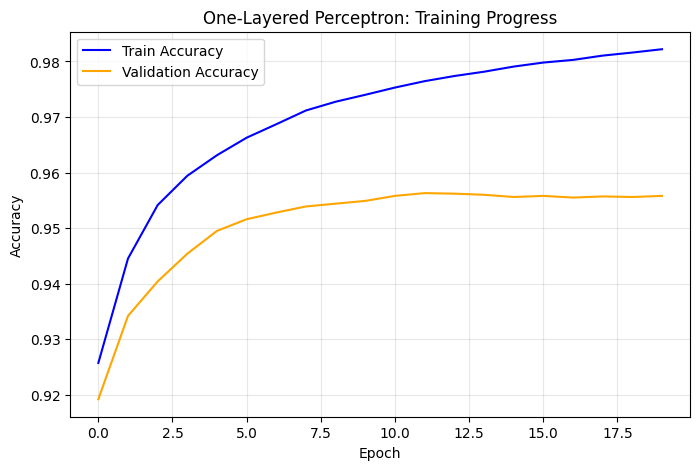

In [51]:


net = Net()
net.add(Linear(784, 30))
net.add(Tanh())
net.add(Linear(30, 10))
net.add(Softmax())
loss = CrossEntropyLoss()

n_epochs = 20
batch_size = 32
lr = 0.1
res = train_model(n_epochs, net, loss, features_train, labels_train, features_test, labels_test, batch_size=32, lr=0.1)
print(f"\nFinal Train Accuracy: {res[0][-1]:.4f}")
print(f"Final Validation Accuracy: {res[1][-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(res[0], label='Train Accuracy', color='blue')
plt.plot(res[1], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('One-Layered Perceptron: Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Try to understand if overfitting took place, and adjust layer parameters to improve accuracy


In [55]:
import numpy as np
train_acc = np.array(res[0])
val_acc = np.array(res[1])
epochs = np.arange(1, len(train_acc) + 1)

gaps = train_acc - val_acc
max_gap = np.max(gaps)

print(f"Final Train Acc: {train_acc[-1]:.4f}, Final Val Acc: {val_acc[-1]:.4f}")
print(f"Max Gap: {max_gap:.4f} (at epoch {np.argmax(gaps) + 1})")

# If val doesn't improve for last 5 epochs
val_improvements = np.diff(val_acc[-5:])
if np.all(val_improvements <= 0.001):
    print("no change maybe overfitting or underfitting.")
else:
    print("Train for more")

Final Train Acc: 0.9822, Final Val Acc: 0.9558
Max Gap: 0.0264 (at epoch 20)
no change maybe overfitting or underfitting.


In [57]:
class LinearL2(Linear):  # Subclass of Linear
    def __init__(self, nin, nout, lambda_=0.001):
        super().__init__(nin, nout)  # Call parent's init
        self.lambda_ = lambda_

    def update(self, lr):
        self.W -= lr * (self.dW + self.lambda_ * self.W)
        self.b -= lr * self.db

The accuracies for Epoch5 is train: 0.9645 val: 0.9525
The accuracies for Epoch10 is train: 0.9750 val: 0.9621
The accuracies for Epoch15 is train: 0.9791 val: 0.9656
The accuracies for Epoch20 is train: 0.9811 val: 0.9666

Final Train Accuracy: 0.9822
Final Validation Accuracy: 0.9558


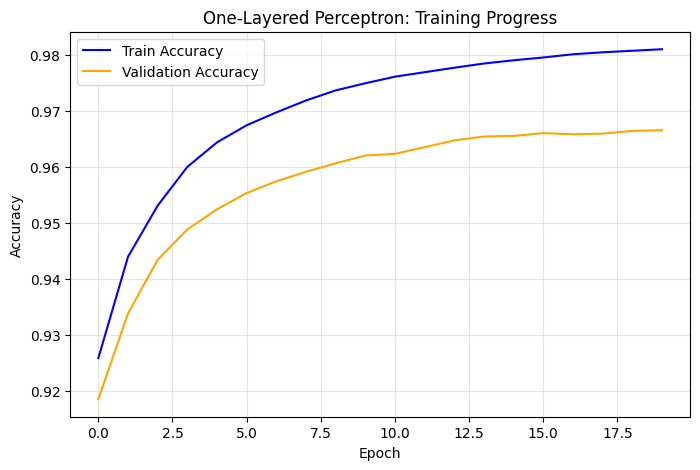

In [59]:
net_adjusted = Net()
net_adjusted.add(LinearL2(784, 100, lambda_=0.001))
net_adjusted.add(Tanh())
net_adjusted.add(LinearL2(100, 10, lambda_=0.001))
net_adjusted.add(Softmax())
loss_adjusted = CrossEntropyLoss()
n_epochs = 20
batch_size = 32
lr = 0.1
res_adjusted = train_model(n_epochs, net_adjusted, loss_adjusted, features_train, labels_train, features_test, labels_test, batch_size, lr)

print(f"\nFinal Train Accuracy: {res_adjusted[0][-1]:.4f}")
print(f"Final Validation Accuracy: {res_adjusted[1][-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(res_adjusted[0], label='Train Accuracy', color='blue')
plt.plot(res_adjusted[1], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('One-Layered Perceptron: Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.






In [ ]:
np.random.seed(42)
net_2tanh = Net()
net_2tanh.add(LinearL2(784, 100, lambda_=0.001))  # Hidden1
net_2tanh.add(Tanh())
net_2tanh.add(LinearL2(100, 50, lambda_=0.001))   # Hidden2
net_2tanh.add(Tanh())
net_2tanh.add(LinearL2(50, 10, lambda_=0.001))    # Output (L2 optional here)
net_2tanh.add(Softmax())
loss_2tanh = CrossEntropyLoss()

res_2tanh = train_model(n_epochs, net_2tanh, loss_2tanh, features_train, labels_train,
                       features_test, labels_test, batch_size, lr)

plt.figure(figsize=(6, 4))
plt.plot(res_2tanh[0], label='Train Acc', color='blue')
plt.plot(res_2tanh[1], label='Val Acc', color='orange')
plt.title('2-Layer Perceptron (Tanh)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The accuracies for Epoch5 is train: 0.9737 val: 0.9586
The accuracies for Epoch10 is train: 0.9809 val: 0.9621
The accuracies for Epoch15 is train: 0.9822 val: 0.9644
The accuracies for Epoch20 is train: 0.9836 val: 0.9643


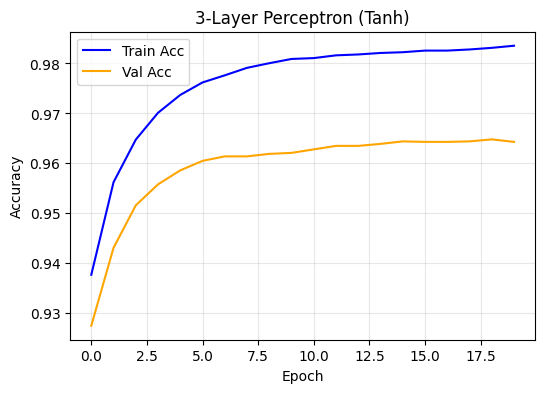

In [60]:
np.random.seed(42)
net_3tanh = Net()
net_3tanh.add(LinearL2(784, 128, lambda_=0.001))  # Hidden lay 1
net_3tanh.add(Tanh())
net_3tanh.add(LinearL2(128, 64, lambda_=0.001))   # Hidden lay 2
net_3tanh.add(Tanh())
net_3tanh.add(LinearL2(64, 32, lambda_=0.001))    # Hidden lay 3
net_3tanh.add(Tanh())
net_3tanh.add(LinearL2(32, 10, lambda_=0.001))    # Output
net_3tanh.add(Softmax())
loss_3tanh = CrossEntropyLoss()

res_3tanh = train_model(n_epochs, net_3tanh, loss_3tanh, features_train, labels_train, features_test, labels_test, batch_size, lr)
plt.figure(figsize=(6, 4))
plt.plot(res_3tanh[0], label='Train Acc', color='blue')
plt.plot(res_3tanh[1], label='Val Acc', color='orange')
plt.title('3-Layer Perceptron (Tanh)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [62]:
np.random.seed(42)
net_3relu = Net()
net_3relu.add(LinearL2(784, 128, lambda_=0.001))
net_3relu.add(ReLU())
net_3relu.add(LinearL2(128, 64, lambda_=0.001))
net_3relu.add(ReLU())
net_3relu.add(LinearL2(64, 32, lambda_=0.001))
net_3relu.add(ReLU())
net_3relu.add(LinearL2(32, 10, lambda_=0.001))
net_3relu.add(Softmax())
loss_3relu = CrossEntropyLoss()

res_3relu = train_model(n_epochs, net_3relu, loss_3relu, features_train, labels_train, features_test, labels_test, batch_size, lr)


The accuracies for Epoch5 is train: 0.9799 val: 0.9655
The accuracies for Epoch10 is train: 0.9878 val: 0.9705
The accuracies for Epoch15 is train: 0.9893 val: 0.9699
The accuracies for Epoch20 is train: 0.9936 val: 0.9727


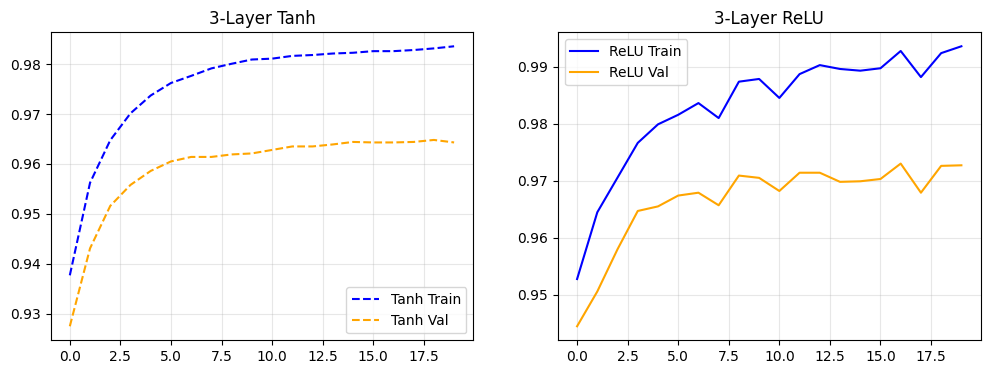

3 Perceptron Layer Accureacy
Final RELU Train Accuracy: 0.9936
Final RELU Validation Accuracy: 0.9727
Final tanh Train Accuracy: 0.9836
Final tanh Validation Accuracy: 0.9643


In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(res_3tanh[0], label='Tanh Train', color='blue', linestyle='--')
ax[0].plot(res_3tanh[1], label='Tanh Val', color='orange', linestyle='--')
ax[0].set_title('3-Layer Tanh')
ax[0].legend(); ax[0].grid(True, alpha=0.3)

ax[1].plot(res_3relu[0], label='ReLU Train', color='blue')
ax[1].plot(res_3relu[1], label='ReLU Val', color='orange')
ax[1].set_title('3-Layer ReLU')
ax[1].legend(); ax[1].grid(True, alpha=0.3)
plt.show()
print("3 Perceptron Layer Accureacy")
print(f"Final RELU Train Accuracy: {res_3relu[0][-1]:.4f}")
print(f"Final RELU Validation Accuracy: {res_3relu[1][-1]:.4f}")
print(f"Final tanh Train Accuracy: {res_3tanh[0][-1]:.4f}")
print(f"Final tanh Validation Accuracy: {res_3tanh[1][-1]:.4f}")

Conclusion: I believe that adding more layer increases accuracy, for the activation layer function RELU has avery massive increase in accuracy with the same gap as the tanh.